In [2]:
import geopandas as geopd
import pandas as pd
from shapely.geometry import box

import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds
from rasterio.features import rasterize

import watershed_utils as wu

import numpy as np

try:# second time
    from whitebox.WBT.whitebox_tools import WhiteboxTools
except:# first time
    from whitebox.whitebox_tools import WhiteboxTools

import os

from time import sleep

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"]  = 400
plt.style.use('dark_background')

In [3]:
# Options
# This has to be large enough to ensure that rivers don't get split by edge effects 
#buffer_d = 10_000

root = "/media/iielse/T9/gisT7/korkeusmalli_10_m"

# Path on fossa local drive
#if not os.path.exists(root):
    #root = '/home/iiro/980/GIS980/korkeusmalli_10_m'
dem_vrt_path = os.path.join(root, "korkeusmalli_10_m.vrt")

catchments_path = "/home/iielse/Documents/DIWA/data/CAMELS-FI catchments/CAMELS-FI_basins.gpkg"
network_path = "/home/iielse/Documents/DIWA/data/omat digitoinnit/uoma10_no_bifurcation.gpkg" 
raise_vector_path = "/home/iielse/Documents/DIWA/data/omat digitoinnit/watershed_fixes.gpkg"

# To limit memory usage, each catchment is processed separately

In [4]:
catchments = geopd.read_file(catchments_path, layer='v1')
bboxs = catchments.envelope
#catchments['bbox'] = bboxs

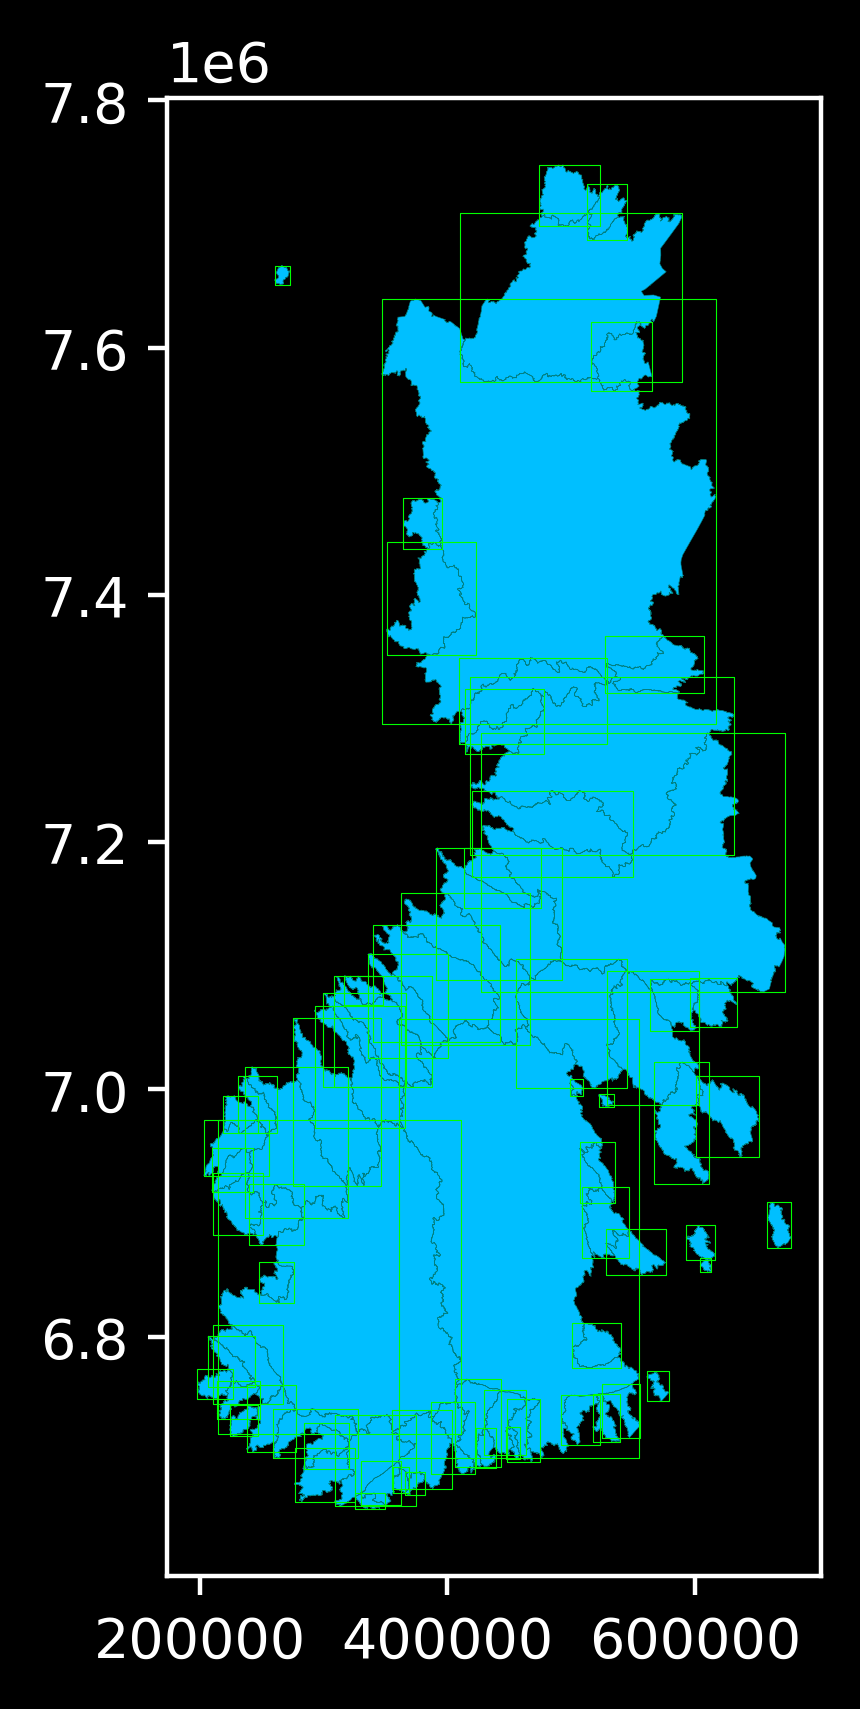

In [4]:

ax = catchments.boundary.plot(color='teal', linewidth=0.1)
ax = bboxs.boundary.plot(ax=ax, color='lime', linewidth=0.2)
ax = catchments.plot(ax=ax, color='deepskyblue')

(np.float64(162490.5),
 np.float64(712919.5),
 np.float64(6595345.0),
 np.float64(7813155.0))

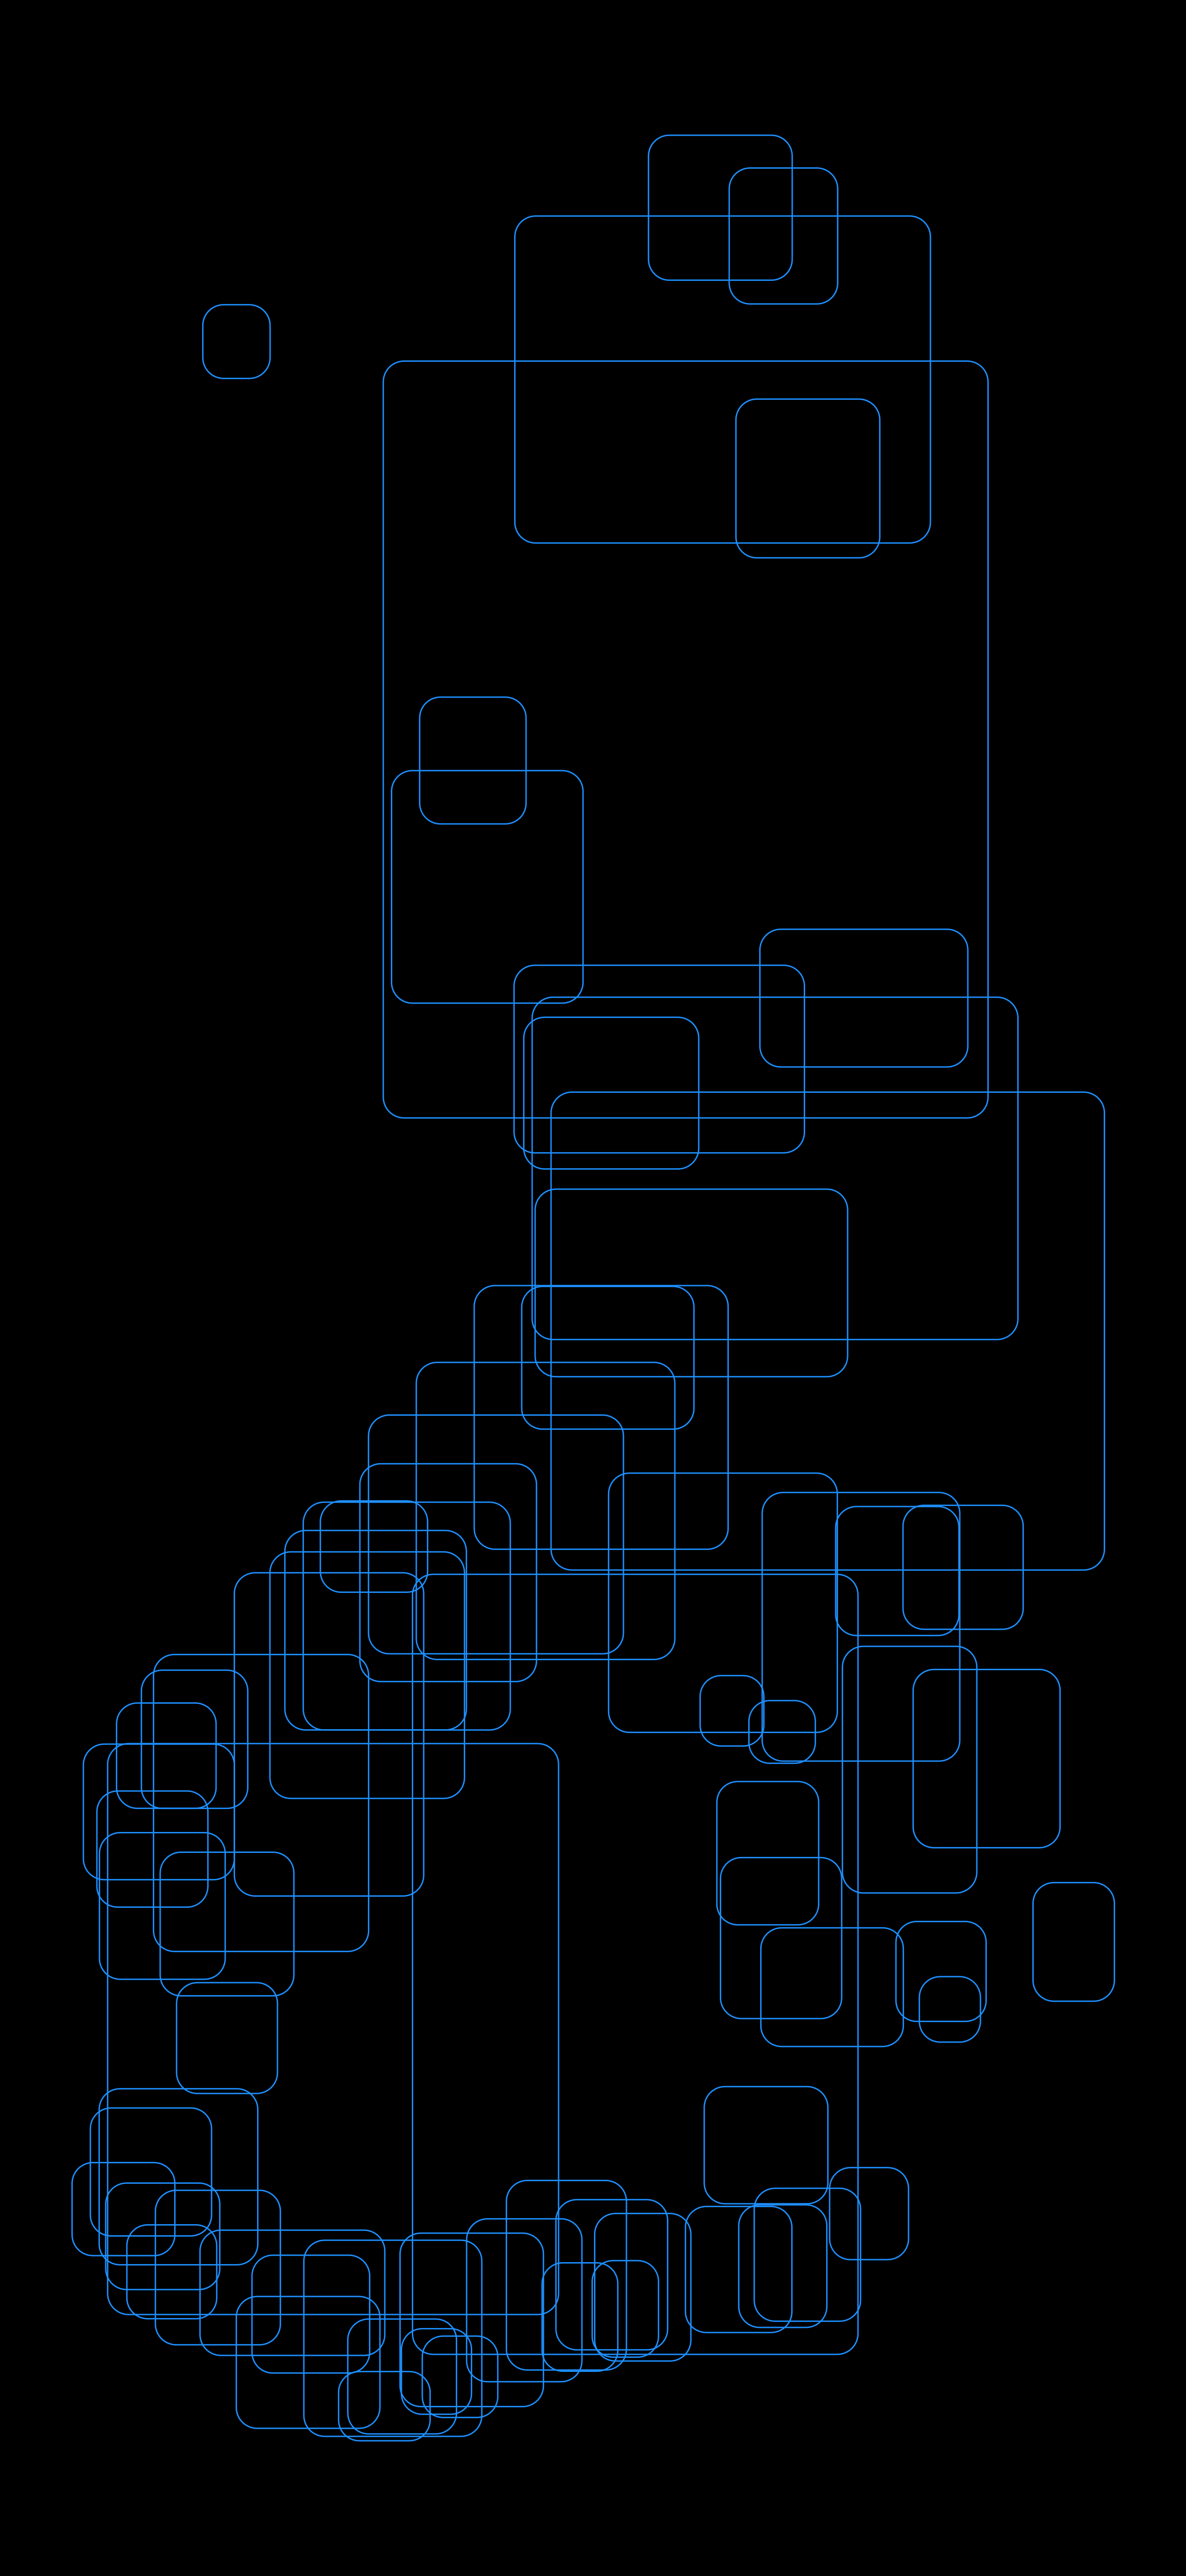

In [5]:
ax = bboxs.buffer(10_000).boundary.plot(linewidth=0.5, color='dodgerblue', figsize=(11.7, 16.5))
ax.axis("off")
#plt.savefig("/home/iiro/Documents/DIWA/art/buffered_catchment_bboxes.png", dpi=500)

# To ensure working edges, the dem is read from a vrt with an area that is buffered by a few pixels width. 
- The results are cropped to the original catchment
- catchment is written to a new directory
- a text file of paths is created
### The order of operations is:
- burn (dig) the river network
- raise the boundaries of watershed to prevent watershed bleeding
- dig the intersection of the boundaries and river network to be in a pit
- breach depressions
- d8 pointer
- d8 flow accumulation
- value clipping the flow accumulation

In [21]:
print("burn")
burn_paths = wu.burn_river_graph(
    catchments, network_path, root,
    dem_vrt_path, buffer_d=20)

burn


  0%|          | 0/74 [00:00<?, ?it/s]

In [ ]:
burn_paths = os.path.join(root, "burn_10m.txt")
print("raise")
"""
raise_paths = wu.paralell_process_catchments(
    "raise", catchments, root,
    burn_paths, buffer_d=20)
"""
# Adding extra walls to places that proved problematic for the breach algorithm
raise_paths = wu.paralell_process_catchments(
    "raise", catchments, root,
    burn_paths, buffer_d=20, raise_path=raise_vector_path)
print("dig_intersection")
dig_intersection_paths = wu.paralell_process_catchments(
    "dig_intersection", catchments, root, raise_paths,
    buffer_d=20, network_path=network_path)

In [7]:
dig_intersection_paths = os.path.join(root, "dig_intersection_10m.txt")
print("breach")
# Requires 64 GB to run parallel because just Kemijoki uses 18 GB
breach_paths = wu.paralell_process_catchments(
    "breach", catchments, root,
    dig_intersection_paths, buffer_d=20, n_cpu=6)
print("d8_pointer")
d8_paths = wu.paralell_process_catchments(
    "d8_pointer", catchments, root,
    breach_paths, buffer_d=20)
print("d8_flow_accumulation")
flow_acc_paths = wu.paralell_process_catchments(
    "d8_flow_accumulation", catchments, root,
    d8_paths, buffer_d=20)

print("stream_thresholding")
stream_paths = wu.paralell_process_catchments(
    "stream_thresholding", catchments, root,
    flow_acc_paths, buffer_d=20)

breach


DONE:   0%|          | 0/74 [00:00<?, ?it/s]

d8_pointer


DONE:   0%|          | 0/74 [00:00<?, ?it/s]

d8_flow_accumulation


DONE:   0%|          | 0/74 [00:00<?, ?it/s]

stream_thresholding


DONE:   0%|          | 0/74 [00:00<?, ?it/s]

In [5]:
def process_individual_catchments(operation_name, catchments, root, catchment_id, buffer_d,
                                  source_txt_path=None, network_path=None, raise_path=None,
                                  verbose=False, src_vrt_path=None):
    """ Convenience wrapper for processing the catchment tiffs
    """
    if operation_name != "burn":
        sources = pd.read_csv(source_txt_path, header=None, names=["path"])
    """
    tmp_dir = "/tmp/stream_processing"
    if not os.path.isdir(tmp_dir):
            os.mkdir(tmp_dir)
    """
    
    #src_tmp_path = os.path.join(tmp_dir, "source.tif") 
    dst_dir = os.path.join(root, operation_name) 
    if not os.path.isdir(dst_dir):
        os.makedirs(dst_dir)
    
    # Text file that contains path of all the processed files
    dst_txt_path = os.path.join(root, f"{operation_name}_10m.txt")
    # The resulting vrt_path
    #dst_vrt_path = os.path.join(root, f"{operation_name}_10m.vrt")
    
    wbt = WhiteboxTools()
    wbt.set_verbose_mode(verbose)
    
    dst_file_paths = []
    # a separate counter is needed
    k = 0
    with tqdm(catchments.iterrows(), total=len(catchments)) as pbar:
        for j, catchment in pbar:
            if j != catchment_id:
                k +=1
                continue
            pbar.set_description(f" Doing {operation_name} for catchment {j}")
            
            # Changing the catchment from series to dataframe 
            catchment = geopd.GeoDataFrame(
                    dict(zip(list(catchment.index), list(catchment.values))),
                    crs=catchments.crs, geometry='geometry', index=[0])
    
            catchment_minx = catchment.bounds.at[0, 'minx']
            catchment_miny = catchment.bounds.at[0, 'miny']
            catchment_maxx = catchment.bounds.at[0, 'maxx']
            catchment_maxy = catchment.bounds.at[0, 'maxy']
            
            # Buffering so that edge effects can be mitigated
            buffer = catchment.buffer(buffer_d, join_style='mitre')
            bounds = buffer.bounds
    
            minx = bounds.at[0, 'minx']
            miny = bounds.at[0, 'miny']
            maxx = bounds.at[0, 'maxx']
            maxy = bounds.at[0, 'maxy']
    
            # Fetching the filename
            if operation_name != "burn":
                src_path = sources.at[k, 'path']
            # If the buffer falls outside of the bounds of vrt, the portion is filled with nodata
            """
            with rasterio.open(src_path) as src:
                profile = src.profile
                values = src.read(
                    1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
                    boundless=True, fill_value=profile['nodata'])
            """    
                #mask = src.read_masks(window=from_bounds(minx, miny, maxx, maxy, src.transform))
            """For some reason, the dataset contains completely empty DEMs (for example X5142).
            These are skipped and not added anywhere. The indexes are then added to a list and removed from catchments
            """
            """
            unique = np.unique(values)
            if unique.max() < 0:
                continue
            
            # Updating the profile and recalculating the transform to match the values
            profile['transform'] = rasterio.transform.from_bounds(
                minx, miny, maxx, maxy, values.shape[1], values.shape[0])
            profile['width'] = values.shape[1]
            profile['height'] = values.shape[0]
            profile['driver'] = 'GTiff'
            
            # Saving the opened raster as a temporary file
            with rasterio.open(src_tmp_path, 'w', **profile) as dst:
                dst.write(values, 1)
            """
            dst_path = os.path.join(dst_dir, f"{operation_name}_{j}.tif")
            dst_file_paths.append(dst_path)

            if operation_name == "burn":
                # Reading the portion of teh river network that is needed
                network = geopd.read_file(network_path, bbox=(minx, miny, maxx, maxy))
                
                """ reading only the portion of the raster that falls on the buffered area.
                The catchment and dataset need to be in the same projection.
                If the buffer falls outside of the bounds of vrt, the portion is filled with nodata
                """
                with rasterio.open(src_vrt_path) as src:
                    profile = src.profile
                    values = src.read(
                        1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
                        boundless=True, fill_value=profile['nodata'])
                    
                    #mask = src.read_masks(window=from_bounds(minx, miny, maxx, maxy, src.transform))
                
                # Updating the profile and recalculating the transform to match the values
                profile['transform'] = rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[1], values.shape[0])
                profile['width'] = values.shape[1]
                profile['height'] = values.shape[0]
                profile['driver'] = 'GTiff'
    
                # Rasterizing the network.
                rasterized = rasterize(
                    network['geometry'], (profile['height'], profile['width']),
                    dtype=profile['dtype'], transform=profile['transform'])
                
                # burning the river channels 1 meter deep
                values = np.where(rasterized==1, values - 1, values)
                
                # Saving the opened raster as a temporary file
                with rasterio.open(dst_path, 'w', **profile) as dst:
                    dst.write(values, 1)
            
            elif operation_name == "raise":
                # Raise is either performed with the boundary of the watershed or a custom file, if it is provided
                if raise_path != None:
                    boundary = geopd.read_file(raise_path, bbox=(minx, miny, maxx, maxy))
                        
                else: # default, use the watershed boundary
                    boundary = catchment.boundary.explode().reset_index()
                    boundary['length'] = boundary.length
                    boundary = boundary.loc[boundary['length'] > 160]
                    boundary = boundary.rename({0:'geometry'}, axis=1)

                # There are no changes for this watershed, we can just copy the existing file
                if len(boundary) == 0:
                    # if there are no changes and the paths stay the same, there is no need to copy
                    if src_path != dst_path:
                        copyfile(src_path, dst_path)
                
                else:
                    with rasterio.open(src_path) as src:
                        values = src.read(1)
                        profile = src.profile
                        mask = src.read_masks(1)
    
                    # Rasterizing the catchment boundary.
                    rasterized = rasterize(
                        boundary['geometry'], (profile['height'], profile['width']),
                        dtype=profile['dtype'], transform=profile['transform'])
                
                    # raising the catchment boundaries as walls
                    values = np.where(rasterized==1, values + 100, values)
    
                    with rasterio.open(dst_path, 'w', **profile) as dst:
                            dst.write(values, 1)
            elif operation_name == "dig_intersection":
                """ Walls that are raised around the catchments need to be breached on the pour point of the catchment
                """
                # This operation requires additional keyword argument to function
                assert network_path is not None, "operation dig_intersection requires the keyword argument network_path"
                boundary = catchment.boundary.explode().reset_index()
                boundary['length'] = boundary.length
                boundary = boundary.loc[boundary['length'] > 160]
                boundary = boundary.rename({0:'geometry'}, axis=1)
                boundary = boundary.set_geometry('geometry', crs=catchment.crs)
                
                network = geopd.read_file(network_path, bbox=(minx, miny, maxx, maxy))
                intersection = geopd.overlay(boundary, network, keep_geom_type=False)

                if len(intersection) == 0:
                    print(f"{operation_name} failed for catchment {j} because there were no intersections")
                    return boundary, network, intersection, catchment # for debugging
                    #continue
                intersection['geometry'] = intersection.buffer(10, cap_style='square')
                with rasterio.open(src_path) as src:
                    values = src.read(1)
                    profile = src.profile
                    mask = src.read_masks(1)

                rasterized = rasterize(
                    intersection['geometry'], (profile['height'], profile['width']),
                    dtype=profile['dtype'], transform=profile['transform'])
                values = np.where(rasterized==1, values - 110, values)

                with rasterio.open(dst_path, 'w', **profile) as dst:
                        dst.write(values, 1)
                
            elif operation_name == "breach":
                status = wbt.breach_depressions_least_cost(src_path, dst_path, dist=10, max_cost=50)

                
            elif operation_name == "d8_pointer":
                status = wbt.d8_pointer(src_path, dst_path)

            elif operation_name == "d8_flow_accumulation":
                status = wbt.d8_flow_accumulation(src_path, dst_path, pntr=True)

            elif operation_name == "stream_thresholding":
                with rasterio.open(src_path) as src:
                    values = src.read(1)
                    profile = src.profile
                    mask = src.read_masks(1)
                # value clipping, 40_000 is required for one of pesiös locations. 55_000 is closer to SYKES flow channel estimate
                values = np.where(values > 40_000, 1, 0).astype('uint8')
                profile['dtype'] = 'uint8'
                # update nodata to 255
                values = np.where(mask == 0, 255, values)
                profile['nodata'] = 255
                
                with rasterio.open(dst_path, 'w', **profile) as dst:
                        dst.write(values, 1)
            

            else:
                raise Exception(f"unregocnized operation name {operation_name}")

            # The raster is not clipped so that edge effects can be avoided in future prosessing round
            # clipping the raster and moving it to the correct location
            """
            with rasterio.open(dst_path) as src:
                profile = src.profile
                values = src.read(
                    1, window=from_bounds(
                        catchment_minx, catchment_miny, catchment_maxx,
                        catchment_maxy, src.transform),
                    boundless=True, fill_value=profile['nodata'])
            
            profile['transform'] = rasterio.transform.from_bounds(
                catchment_minx, catchment_miny, catchment_maxx,
                catchment_maxy, values.shape[1], values.shape[0])
            profile['width'] = values.shape[1]
            profile['height'] = values.shape[0]
            """
    
            k +=1

    """       
    # Writing the files to a file list
    with open(dst_txt_path, 'w') as fp:
        for name in dst_file_paths:
            fp.write(f"{name}\n")
    """
    
    return dst_txt_path

In [7]:
# Oulujoki 3
# Kalajoki 9
problem_catchment = 72
burn_paths = process_individual_catchments(
    "burn", catchments, root,
    problem_catchment,  buffer_d=20, network_path=network_path, 
    src_vrt_path=dem_vrt_path)

#burn_paths = "/media/iiro/T9/gisT7/korkeusmalli_10_m/burn_10m.txt"
"""
raise_paths = process_individual_catchments(
    "raise", catchments, root,
    problem_catchment,  buffer_d=20)
"""
# Adding extra walls to places that proved problematic for the breach algorithm and also around all lvl 3 catchments
raise_paths = process_individual_catchments(
    "raise", catchments, root,
    problem_catchment, buffer_d=20, source_txt_path=burn_paths, raise_path=raise_vector_path)
dig_intersection_paths = process_individual_catchments(
    "dig_intersection", catchments, root,
    problem_catchment, buffer_d=20, source_txt_path=raise_paths, network_path=network_path)

breach_paths = process_individual_catchments(
    "breach", catchments, root,
    problem_catchment, buffer_d=20, source_txt_path=dig_intersection_paths, verbose=True)
d8_paths = process_individual_catchments(
    "d8_pointer", catchments, root,
    problem_catchment, buffer_d=20, source_txt_path=breach_paths)

flow_acc_paths = process_individual_catchments(
    "d8_flow_accumulation", catchments, root,
    problem_catchment, buffer_d=20, source_txt_path=d8_paths)
stream_paths = process_individual_catchments(
    "stream_thresholding", catchments, root,
    problem_catchment, buffer_d=20, source_txt_path=flow_acc_paths)

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

./whitebox_tools --run="BreachDepressionsLeastCost" --wd="/Users/johnlindsay/Downloads/" --dem='/media/iielse/T9/gisT7/korkeusmalli_10_m/dig_intersection/dig_intersection_72.tif' --output='/media/iielse/T9/gisT7/korkeusmalli_10_m/breach/breach_72.tif' --dist='10' --max_cost='50' --min_dist --fill -v --compress_rasters=False

*****************************************
* Welcome to BreachDepressionsLeastCost *
* Powered by WhiteboxTools              *
* www.whiteboxgeo.com                   *
*****************************************
Reading data...
Finding pits: 0%
Finding pits: 1%
Finding pits: 2%
Finding pits: 3%
Finding pits: 4%
Finding pits: 5%
Finding pits: 6%
Finding pits: 7%
Finding pits: 8%
Finding pits: 9%
Finding pits: 10%
Finding pits: 11%
Finding pits: 12%
Finding pits: 13%
Finding pits: 14%
Finding pits: 15%
Finding pits: 16%
Finding pits: 17%
Finding pits: 18%
Finding pits: 19%
Finding pits: 20%
Finding pits: 21%
Finding pits: 22%
Finding pits: 23%
Finding pits: 24%
Finding

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

In [20]:
burn_paths

'/media/iielse/T9/gisT7/korkeusmalli_10_m/burn_10m.txt'

In [12]:
breach_paths = "/media/iiro/T9/gisT7/korkeusmalli_10_m/breach_10m.txt"
d8_paths = wu.process_catchments(
    "d8_pointer", catchments, root,
    breach_paths, buffer_d=20)
flow_acc_paths = wu.process_catchments(
    "d8_flow_accumulation", catchments, root,
    d8_paths, buffer_d=20)
stream_paths = wu.process_catchments(
    "stream_thresholding", catchments, root,
    flow_acc_paths, buffer_d=20)

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

In [11]:
print(breach_paths)

/media/iiro/T9/gisT7/korkeusmalli_10_m/breach_10m.txt


In [5]:
burn_paths = "/media/iiro/T9/gisT7/korkeusmalli_10_m/burn_10m.txt"


  0%|          | 0/76 [00:00<?, ?it/s]

In [6]:
# Adding extra walls to places that proved problematic for the breach algorithm
raise_paths = wu.process_catchments("raise", catchments, root, raise_paths, buffer_d=20, raise_path=raise_vector_path)

  0%|          | 0/76 [00:00<?, ?it/s]

In [ ]:
network_path = "/home/iiro/Documents/DIWA/data/omat digitoinnit/uoma10_no_bifurcation.gpkg" 
#raise_paths = "/media/iiro/T9/gisT7/korkeusmalli_10_m/raise_10m.txt"
dig_intersection_paths = wu.process_catchments(
    "dig_intersection", catchments, root, raise_paths,
    buffer_d=20, network_path=network_path)

In [5]:
dig_intersection_paths = "/media/iiro/T9/gisT7/korkeusmalli_10_m/dig_intersection_10m.txt"
breach_paths = wu.process_catchments("breach", catchments, root, dig_intersection_paths, buffer_d=20)
d8_paths = wu.process_catchments("d8_pointer", catchments, root, breach_paths, buffer_d=20)
flow_acc_paths = wu.process_catchments("d8_flow_accumulation", catchments, root, d8_paths, buffer_d=20)
stream_paths = wu.process_catchments("stream_thresholding", catchments, root, flow_acc_paths, buffer_d=20)

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [7]:
def mass_process_raster_grid(operation_name, catchments, root, src_vrt_path, buffer_d):
    # original version
    tmp_dir = "/tmp/stream_processing"
    if not os.path.isdir(tmp_dir):
            os.mkdir(tmp_dir)
    
    
    src_tmp_path = os.path.join(tmp_dir, "source.tif") 
    dst_tmp_path = os.path.join(tmp_dir, f"{operation_name}.tif")  
    
    # Text file that contains path of all the processed files
    dst_txt_path = os.path.join(root, f"{operation_name}_10m.txt")
    # The resulting vrt_path
    dst_vrt_path = os.path.join(root, f"{operation_name}_10m.vrt")
    
    
    
    wbt = WhiteboxTools()
    wbt.set_verbose_mode(False)
    
    
    dst_file_paths = []
    
    with tqdm(catchments.iterrows(), total=len(catchments)) as pbar:
        for i, catchment in pbar:
            # for testing
            if i < 300 or i > 400:
                continue
            
            pbar.set_description(f" Doing {operation_name} for catchment {catchment.label}")

            
            # Changing the catchment from series to dataframe 
            catchment = geopd.GeoDataFrame(
                    dict(zip(list(catchment.index), list(catchment.values))),
                    crs=catchments.crs, geometry='geometry', index=[0])
    
            catchment_minx = catchment.bounds.at[0, 'minx']
            catchment_miny = catchment.bounds.at[0, 'miny']
            catchment_maxx = catchment.bounds.at[0, 'maxx']
            catchment_maxy = catchment.bounds.at[0, 'maxy']
            
            # Buffering so that edge effects can be mitigated
            buffer = catchment.buffer(buffer_d, join_style='mitre')
            bounds = buffer.bounds
    
            minx = bounds.at[0, 'minx']
            miny = bounds.at[0, 'miny']
            maxx = bounds.at[0, 'maxx']
            maxy = bounds.at[0, 'maxy']
    
            """ reading only the portion of the raster that falls on the buffered area.
            The catchment and dataset need to be in the same projection.
            If the buffer falls outside of the bounds of vrt, teh portion is filled with nodata
            """
            with rasterio.open(src_vrt_path) as src:
                profile = src.profile
                values = src.read(
                    1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
                    boundless=True, fill_value=profile['nodata'])
                
                #mask = src.read_masks(window=from_bounds(minx, miny, maxx, maxy, src.transform))
            """For some reason, the dataset contains completely empty DEMs (for example X5142).
            These are skipped and not added anywhere. The indexes are then added to a list and removed from catchments
            """
            unique = np.unique(values)
            if unique.max() < 0:
                continue
            
            # Updating the profile and recalculating the transform to match the values
            profile['transform'] = rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[1], values.shape[0])
            profile['width'] = values.shape[1]
            profile['height'] = values.shape[0]
            profile['driver'] = 'GTiff'
            
            # Saving the opened raster as a temporary file
            
            
            with rasterio.open(src_tmp_path, 'w', **profile) as dst:
                dst.write(values, 1)

            # The actual processing, depending on the processing option
            if operation_name == "breach":
                status = wbt.breach_depressions_least_cost(src_tmp_path, dst_tmp_path, dist=20, max_cost=100)

            if operation_name == "d8_pointer":
                status = wbt.d8_pointer(src_tmp_path, dst_tmp_path)

            if operation_name == "d8_flow_accumulation":
                status = wbt.d8_flow_accumulation(src_tmp_path, dst_tmp_path, pntr=True)

            if operation_name == "stream_thresholding":
                with rasterio.open(src_tmp_path) as src:
                    values = src.read(1)
                    profile = src.profile
                    mask = src.read_masks(1)
                # clipping
                values = np.where(values > 55_000, 1, 0).astype('uint8')
                profile['dtype'] = 'uint8'
                # update nodata to 255
                values = np.where(mask == 0, 255, values)
                profile['nodata'] = 255
                
                with rasterio.open(dst_tmp_path, 'w', **profile) as dst:
                        dst.write(values, 1)
            
            # clipping the raster and moving it to the correct location
            with rasterio.open(dst_tmp_path) as src:
                profile = src.profile
                values = src.read(
                    1, window=from_bounds(
                        catchment_minx, catchment_miny, catchment_maxx,
                        catchment_maxy, src.transform),
                    boundless=True, fill_value=profile['nodata'])
            
            profile['transform'] = rasterio.transform.from_bounds(
                catchment_minx, catchment_miny, catchment_maxx,
                catchment_maxy, values.shape[1], values.shape[0])
            profile['width'] = values.shape[1]
            profile['height'] = values.shape[0]
            
            # Getting the last three parts of the path
            parts = catchment.loc[0, 'path'].split(os.sep)[-3:]
            path_tail = ''
            for part in parts:
                path_tail = os.path.join(path_tail, part)
            
            dst_path = os.path.join(root, f"{operation_name}", path_tail)
            # creating the directory if it does not exist yet
            dst_dir = os.path.dirname(dst_path)
            if not os.path.isdir(dst_dir):
                os.makedirs(dst_dir)
    
            with rasterio.open(dst_path, 'w', **profile) as dst:
                dst.write(values, 1)
    
            dst_file_paths.append(dst_path)

            
    # Writing the files to a file list
    with open(dst_txt_path, 'w') as fp:
        for name in dst_file_paths:
            fp.write(f"{name}\n")
    
    # Creating the vrt
    subprocess.run(["gdalbuildvrt", "-input_file_list", dst_txt_path, dst_vrt_path])
    return dst_vrt_path


In [11]:
boundary, network, intersection, catchment = dig_intersection_paths
ax = boundary.plot(linewidth=0.5)
ax = network.plot(ax=ax, color='aqua', linewidth=0.5)
ax = intersection.plot(ax=ax, color='coral') 

ValueError: too many values to unpack (expected 4)

In [13]:
intersection

,index,length,objectid,uomanro,muutospvm,uomaluokka,paareitti,pituus_m,pituusalle,pituusyli5,uomapistei,uomapist00,rannikkove,valuyla_pa,valumaalue,paavesisto,vhatunnus,valtio,geometry


In [10]:
burn_paths

'/media/iiro/T9/gisT7/korkeusmalli_10_m/burn_10m.txt'

In [25]:
dem_values.shape

(1220, 2420)

In [12]:
print(miny, maxy)
print(catchment_miny, catchment_maxy)

7769800.0 7782200.0
7770000.0 7782000.0


In [18]:
rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[2], values.shape[1])

Affine(10.0, 0.0, 499980.0,
       0.0, -10.0, 7770020.0)

In [5]:
def breach_catchment(catchments, root, src_vrt_path, buffer_d):
    """
    Conveniece wrapper for automating breaching
    """
    operation_name = "breach"
    
    tmp_dir = "/tmp/stream_processing"
    if not os.path.isdir(tmp_dir):
            os.mkdir(tmp_dir)
    
    
    src_tmp_path = os.path.join(tmp_dir, "source.tif") 
    dst_dir = os.path.join(root, operation_name) 
    if not os.path.isdir(dst_dir):
        os.makedirs(dst_dir)
    
    # Text file that contains path of all the processed files
    dst_txt_path = os.path.join(root, f"{operation_name}_10m.txt")
    # The resulting vrt_path
    #dst_vrt_path = os.path.join(root, f"{operation_name}_10m.vrt")
    
    
    
    wbt = WhiteboxTools()
    wbt.set_verbose_mode(False)
    
    
    dst_file_paths = []
    
    with tqdm(catchments.iterrows(), total=len(catchments)) as pbar:
        for i, catchment in pbar:
                
            pbar.set_description(f" Doing {operation_name} for catchment {i}")
            
            # Changing the catchment from series to dataframe 
            catchment = geopd.GeoDataFrame(
                    dict(zip(list(catchment.index), list(catchment.values))),
                    crs=catchments.crs, geometry='geometry', index=[0])
    
            catchment_minx = catchment.bounds.at[0, 'minx']
            catchment_miny = catchment.bounds.at[0, 'miny']
            catchment_maxx = catchment.bounds.at[0, 'maxx']
            catchment_maxy = catchment.bounds.at[0, 'maxy']
            
            # Buffering so that edge effects can be mitigated
            buffer = catchment.buffer(buffer_d, join_style='mitre')
            bounds = buffer.bounds
    
            minx = bounds.at[0, 'minx']
            miny = bounds.at[0, 'miny']
            maxx = bounds.at[0, 'maxx']
            maxy = bounds.at[0, 'maxy']
    
            """ reading only the portion of the raster that falls on the buffered area.
            The catchment and dataset need to be in the same projection.
            If the buffer falls outside of the bounds of vrt, the portion is filled with nodata
            """
            with rasterio.open(src_vrt_path) as src:
                profile = src.profile
                values = src.read(
                    1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
                    boundless=True, fill_value=profile['nodata'])
                
                #mask = src.read_masks(window=from_bounds(minx, miny, maxx, maxy, src.transform))
            """For some reason, the dataset contains completely empty DEMs (for example X5142).
            These are skipped and not added anywhere. The indexes are then added to a list and removed from catchments
            """
            unique = np.unique(values)
            if unique.max() < 0:
                continue
            
            # Updating the profile and recalculating the transform to match the values
            profile['transform'] = rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[1], values.shape[0])
            profile['width'] = values.shape[1]
            profile['height'] = values.shape[0]
            profile['driver'] = 'GTiff'
            
            # Saving the opened raster as a temporary file
            with rasterio.open(src_tmp_path, 'w', **profile) as dst:
                dst.write(values, 1)

            dst_path = os.path.join(dst_dir, f"{operation_name}_{i}.tif")

            # The actual processing, depending on the processing option
            
            status = wbt.breach_depressions_least_cost(src_tmp_path, dst_path, dist=20, max_cost=100)

            # The raster is not clipped so that edge effects can be avoided in future prosessing round
            # clipping the raster and moving it to the correct location
            
    
            dst_file_paths.append(dst_path)

            
    # Writing the files to a file list
    with open(dst_txt_path, 'w') as fp:
        for name in dst_file_paths:
            fp.write(f"{name}\n")
    
    # Creating the vrt
    #subprocess.run(["gdalbuildvrt", "-input_file_list", dst_txt_path, dst_vrt_path])
    return dst_txt_path

def process_catchments(operation_name, catchments, root, source_txt_path, buffer_d):
    """ Convenience wrapper for processing the catchment tiffs
    """
    sources = pd.read_csv(source_txt_path, header=None, names=["path"])
    
    tmp_dir = "/tmp/stream_processing"
    if not os.path.isdir(tmp_dir):
            os.mkdir(tmp_dir)
    
    
    src_tmp_path = os.path.join(tmp_dir, "source.tif") 
    dst_dir = os.path.join(root, operation_name) 
    if not os.path.isdir(dst_dir):
        os.makedirs(dst_dir)
    
    # Text file that contains path of all the processed files
    dst_txt_path = os.path.join(root, f"{operation_name}_10m.txt")
    # The resulting vrt_path
    #dst_vrt_path = os.path.join(root, f"{operation_name}_10m.vrt")
    
    wbt = WhiteboxTools()
    wbt.set_verbose_mode(False)
    
    dst_file_paths = []
    
    with tqdm(catchments.iterrows(), total=len(catchments)) as pbar:
        for i, catchment in pbar:
            # to fix the problem with one extra watershed
           
            pbar.set_description(f" Doing {operation_name} for catchment {i}")
            
            # Changing the catchment from series to dataframe 
            catchment = geopd.GeoDataFrame(
                    dict(zip(list(catchment.index), list(catchment.values))),
                    crs=catchments.crs, geometry='geometry', index=[0])
    
            catchment_minx = catchment.bounds.at[0, 'minx']
            catchment_miny = catchment.bounds.at[0, 'miny']
            catchment_maxx = catchment.bounds.at[0, 'maxx']
            catchment_maxy = catchment.bounds.at[0, 'maxy']
            
            # Buffering so that edge effects can be mitigated
            buffer = catchment.buffer(buffer_d, join_style='mitre')
            bounds = buffer.bounds
    
            minx = bounds.at[0, 'minx']
            miny = bounds.at[0, 'miny']
            maxx = bounds.at[0, 'maxx']
            maxy = bounds.at[0, 'maxy']
    
            # Fetching the filename
            src_path = sources.at[i, 'path']
            # If the buffer falls outside of the bounds of vrt, the portion is filled with nodata
            with rasterio.open(src_path) as src:
                profile = src.profile
                values = src.read(
                    1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
                    boundless=True, fill_value=profile['nodata'])
                
                #mask = src.read_masks(window=from_bounds(minx, miny, maxx, maxy, src.transform))
            """For some reason, the dataset contains completely empty DEMs (for example X5142).
            These are skipped and not added anywhere. The indexes are then added to a list and removed from catchments
            """
            unique = np.unique(values)
            if unique.max() < 0:
                continue
            
            # Updating the profile and recalculating the transform to match the values
            profile['transform'] = rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[1], values.shape[0])
            profile['width'] = values.shape[1]
            profile['height'] = values.shape[0]
            profile['driver'] = 'GTiff'
            
            # Saving the opened raster as a temporary file
            with rasterio.open(src_tmp_path, 'w', **profile) as dst:
                dst.write(values, 1)

            dst_path = os.path.join(dst_dir, f"{operation_name}_{i}.tif")
            dst_file_paths.append(dst_path)

            if operation_name == "raise":
                boundary = watershed.boundary.explode().reset_index()
                boundary['length'] = boundary.length
                boundary = boundary.loc[boundary['length'] > 160]
                boundary = boundary.rename({0:'geometry'}, axis=1)
                # Rasterizing the catchment boundary.
                rasterized = rasterize(
                    boundary['geometry'], (profile['height'], profile['width']),
                    dtype=profile['dtype'], transform=profile['transform'])
            
                # raising the catchment boundaries as walls
                values = np.where(rasterized==1, values + 10_000, values)

                with rasterio.open(dst_path, 'w', **profile) as dst:
                        dst.write(values, 1)

            if operation_name == "d8_pointer":
                status = wbt.d8_pointer(src_tmp_path, dst_path)

            if operation_name == "d8_flow_accumulation":
                status = wbt.d8_flow_accumulation(src_tmp_path, dst_path, pntr=True)

            if operation_name == "stream_thresholding":
                with rasterio.open(src_tmp_path) as src:
                    values = src.read(1)
                    profile = src.profile
                    mask = src.read_masks(1)
                # value clipping
                values = np.where(values > 55_000, 1, 0).astype('uint8')
                profile['dtype'] = 'uint8'
                # update nodata to 255
                values = np.where(mask == 0, 255, values)
                profile['nodata'] = 255
                
                with rasterio.open(dst_path, 'w', **profile) as dst:
                        dst.write(values, 1)

            # The raster is not clipped so that edge effects can be avoided in future prosessing round
            dst_file_paths.append(dst_path)
            
            # The raster is not clipped so that edge effects can be avoided in future prosessing round
            """
            with rasterio.open(dst_path) as src:
                profile = src.profile
                values = src.read(
                    1, window=from_bounds(
                        catchment_minx, catchment_miny, catchment_maxx,
                        catchment_maxy, src.transform),
                    boundless=True, fill_value=profile['nodata'])
            
            profile['transform'] = rasterio.transform.from_bounds(
                catchment_minx, catchment_miny, catchment_maxx,
                catchment_maxy, values.shape[1], values.shape[0])
            profile['width'] = values.shape[1]
            profile['height'] = values.shape[0]
            """
    
            

            
    # Writing the files to a file list
    with open(dst_txt_path, 'w') as fp:
        for name in dst_file_paths:
            fp.write(f"{name}\n")
    
    # Creating the vrt
    #subprocess.run(["gdalbuildvrt", "-input_file_list", dst_txt_path, dst_vrt_path])
    return dst_txt_path

def burn_river_graph(catchments, river_network_path, root, src_vrt_path, buffer_d, depth=1):
    """
    Artificially deepen the river channels in a given river network to dem
    """
    operation_name = "burn"
    """
    tmp_dir = "/tmp/stream_processing"
    if not os.path.isdir(tmp_dir):
            os.mkdir(tmp_dir)
    """
    
    #src_tmp_path = os.path.join(tmp_dir, "source.tif") 
    dst_dir = os.path.join(root, operation_name) 
    if not os.path.isdir(dst_dir):
        os.makedirs(dst_dir)
    
    # Text file that contains path of all the processed files
    dst_txt_path = os.path.join(root, f"{operation_name}_10m.txt")
    # The resulting vrt_path
    #dst_vrt_path = os.path.join(root, f"{operation_name}_10m.vrt")
    
    
    
    wbt = WhiteboxTools()
    wbt.set_verbose_mode(False)
    
    
    dst_file_paths = []
    
    with tqdm(catchments.iterrows(), total=len(catchments)) as pbar:
        for i, catchment in pbar:
                
            pbar.set_description(f" Doing {operation_name} for catchment {i}")
            
            # Changing the catchment from series to dataframe 
            catchment = geopd.GeoDataFrame(
                    dict(zip(list(catchment.index), list(catchment.values))),
                    crs=catchments.crs, geometry='geometry', index=[0])
    
            catchment_minx = catchment.bounds.at[0, 'minx']
            catchment_miny = catchment.bounds.at[0, 'miny']
            catchment_maxx = catchment.bounds.at[0, 'maxx']
            catchment_maxy = catchment.bounds.at[0, 'maxy']
            
            # Buffering so that edge effects can be mitigated
            buffer = catchment.buffer(buffer_d, join_style='mitre')
            bounds = buffer.bounds
    
            minx = bounds.at[0, 'minx']
            miny = bounds.at[0, 'miny']
            maxx = bounds.at[0, 'maxx']
            maxy = bounds.at[0, 'maxy']

            # Reading the portion of teh river network that is needed
            network = geopd.read_file(river_network_path, bbox=(minx, miny, maxx, maxy))
            
            """ reading only the portion of the raster that falls on the buffered area.
            The catchment and dataset need to be in the same projection.
            If the buffer falls outside of the bounds of vrt, the portion is filled with nodata
            """
            with rasterio.open(src_vrt_path) as src:
                profile = src.profile
                values = src.read(
                    1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
                    boundless=True, fill_value=profile['nodata'])
                
                #mask = src.read_masks(window=from_bounds(minx, miny, maxx, maxy, src.transform))
            """For some reason, the dataset contains completely empty DEMs (for example X5142).
            These are skipped and not added anywhere. The indexes are then added to a list and removed from catchments
            """
            unique = np.unique(values)
            if unique.max() < 0: # TODO check if nodata value is the only value
                continue
            
            # Updating the profile and recalculating the transform to match the values
            profile['transform'] = rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[1], values.shape[0])
            profile['width'] = values.shape[1]
            profile['height'] = values.shape[0]
            profile['driver'] = 'GTiff'

            # Rasterizing the network.
            rasterized = rasterize(
                network['geometry'], (profile['height'], profile['width']),
                dtype=profile['dtype'], transform=profile['transform'])
            
            # burning the river channels 1 meter deep
            values = np.where(rasterized==1, values - depth, values)
            
            dst_path = os.path.join(dst_dir, f"{operation_name}_{i}.tif")
            # Saving the opened raster as a temporary file
            with rasterio.open(dst_path, 'w', **profile) as dst:
                dst.write(values, 1)

            # The raster is not clipped so that edge effects can be avoided in future prosessing round
            dst_file_paths.append(dst_path)

    # Writing the files to a file list
    with open(dst_txt_path, 'w') as fp:
        for name in dst_file_paths:
            fp.write(f"{name}\n")
    
    # Creating the vrt
    #subprocess.run(["gdalbuildvrt", "-input_file_list", dst_txt_path, dst_vrt_path])
    return dst_txt_path

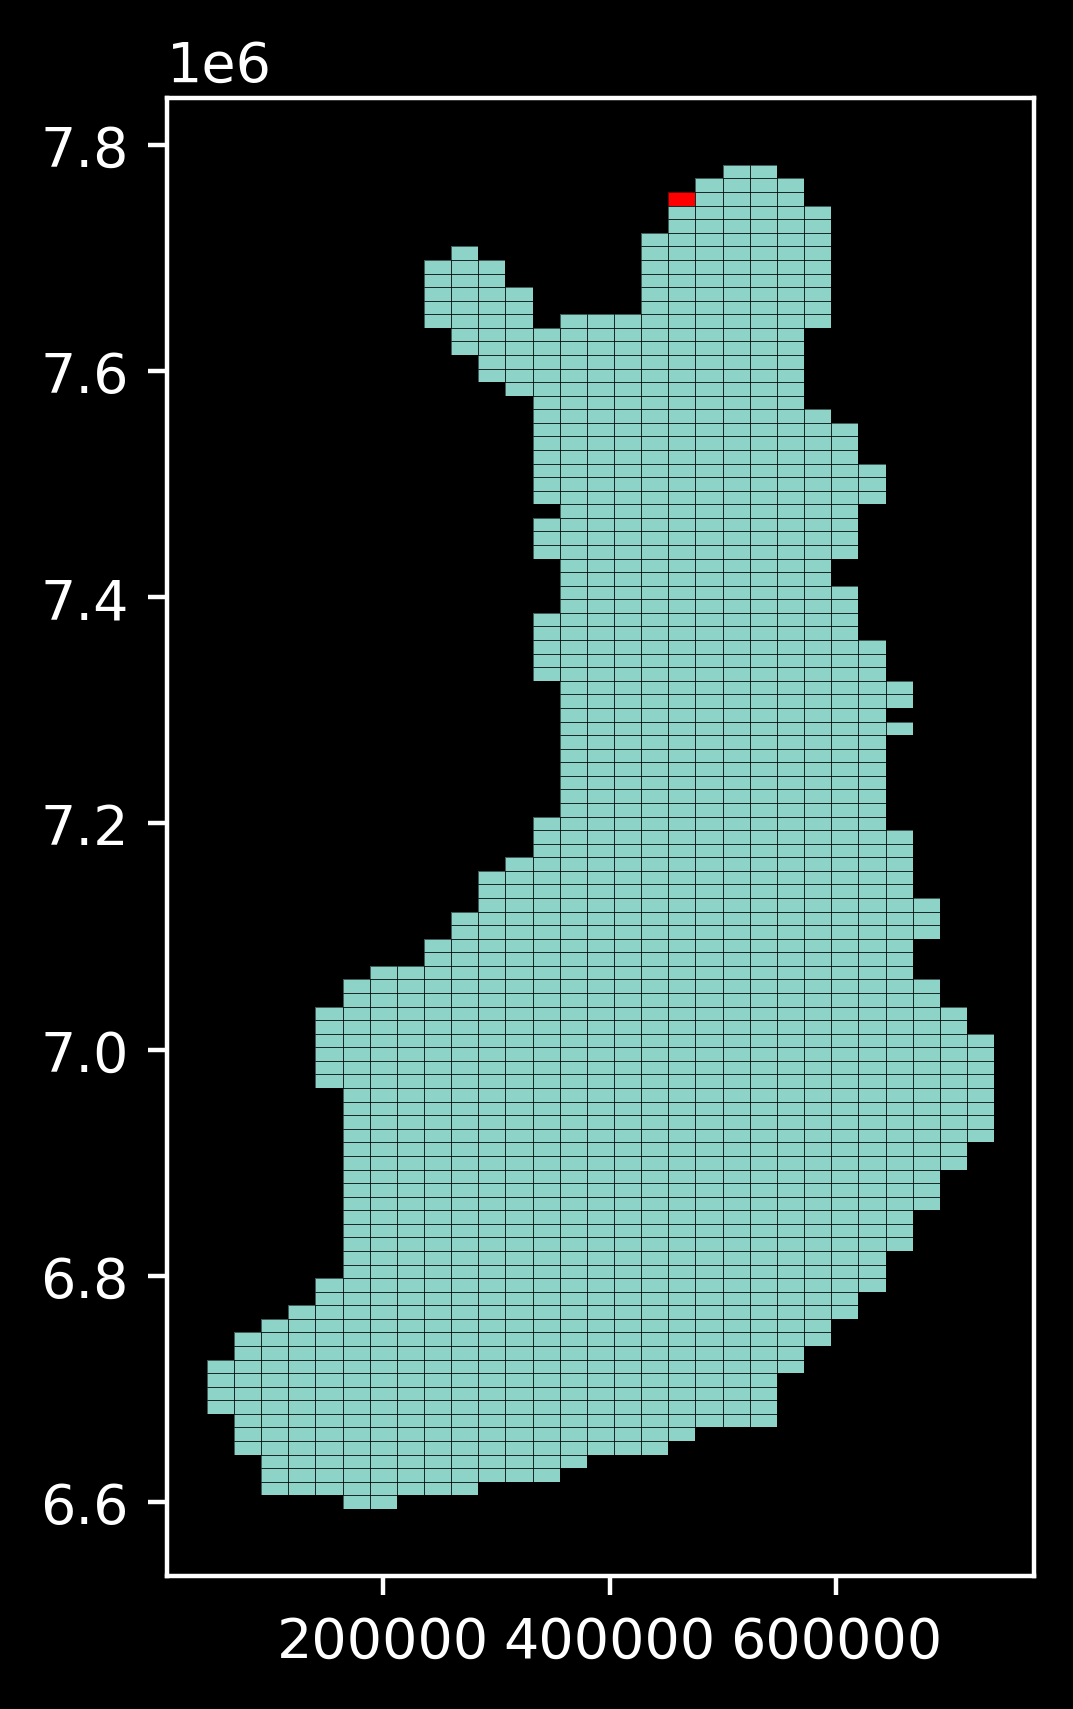

In [121]:
ax = catchments.boundary.plot(color='black', linewidth=0.1)
ax = catchments.plot(ax=ax)
ax = catchment.plot(ax=ax, color='red')

In [122]:
values.shape

(1, 1204, 2404)

In [114]:
unique = np.unique(values)

In [112]:
counts

array([2894416])

In [117]:
unique.max()

-9999.0

In [130]:
os.sep

'/'

'**'

In [40]:
for i in range(7)

'**'

In [44]:
print("test print \nsecond line")

test print 
second line
